In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from glob import glob
from tqdm import tqdm_notebook as tqdm
import os, sys, pickle
sys.path.append('..')

In [3]:
brain_data_dir = 'neural_data/'
checkpoint_dir = 'data_saver/'

### Neural Data Imports + Processing

The easiest method to access and parse the neural data is through a combination of two files: one that contains metadata for each of the cells that appears in the optical physiology assays, and the other that contains each cell's recorded responses. In concert, these two files can be used to subset a variety of targets. Here, we'll use them to subset cells that pass a certain splithalf reliability threshold and are not significantly modulated by running speed (but are significantly modulated by natural scenes).

In [4]:
cell_responses = pickle.load(open(brain_data_dir + 'cell_response_average.pkl', 'rb'))
cell_data = pd.read_csv(brain_data_dir + 'cell_data_plus.csv')
cell_subset = cell_data[((cell_data['p_run_mod_ns'].isna()) | 
                        (cell_data['p_run_mod_ns'] > 0.05)) & 
                        (cell_data['p_ns'] < 0.05) &
                        (cell_data['splithalf_r'] > 0.75)]['cell_specimen_id'].to_list()

### Deep Net Features: Extraction

We've created tools that facilitate feature extraction on almost any feedforward Pytorch architecture. In the example here, we'll be showing an example of a model whose call we've prepackaged as part of a running list to accelerate multiple model comparisons.

In [5]:
sys.path.append('model_opts')
from feature_extraction import *
from model_options import *

In [6]:
stimulus_set = np.load('stimulus_set.npy')

In [7]:
model_options = get_model_options()

Notice the full list includes both the PyTorch model zoo, and the taskonomy models.

In [8]:
list(model_options.keys())[1::9]

['vgg11_imagenet',
 'resnet34_imagenet',
 'densenet201_imagenet',
 'mnasnet0_5_imagenet',
 'r2plus1d_18_kinetics400',
 'depth_zbuffer',
 'nonfixated_pose',
 'taskonomy_random']

We also include a number of standard image transforms, of which we most commonly use *imagenet_from_numpy*.

In [9]:
list(get_image_transforms())

['imagenet_from_numpy', 'imagenet', 'inception', 'segmentation', 'detection']

To use any of these models, we simply construct a call from the model_string, as follows:

In [10]:
model_string = 'resnet18_imagenet'

In [11]:
model_name = model_options[model_string]['model_name']
train_type = model_options[model_string]['train_type']
model_call = model_options[model_string]['call']
image_transforms = get_image_transforms()['imagenet_from_numpy']

Notice here the structure of the model call string, which is the piece of code we evaluate to load the model.

In [12]:
model_name, train_type, model_call

('resnet18', 'imagenet', 'models.resnet18(pretrained=True)')

In [13]:
model = eval(model_call)
model = model.eval()
model = model.cuda()

Next, we transform the stimulus set into a Torch variable and apply the relevant transforms, which we then pass into a convenience function we wrote based on [torchsummary](https://github.com/sksq96/pytorch-summary) that automatically extracts the features from each layer, returning an Ordered dictionary.

In [14]:
model_inputs = Variable(torch.stack([image_transforms(img) for img in stimulus_set])).cuda()
feature_maps = get_all_feature_maps(model, model_inputs)

Each entry in this dictionary is an array corresponding to the number of stimuli by the number of flattened activations in that layer.

In [15]:
feature_maps['Conv2d-1'].shape

(119, 802816)

For the purposes of this demonstration, we'll subset from this dictionary every 3rd convolutional layer.

In [16]:
map_key_subset = list(feature_maps.items())[:3] + list(feature_maps.items())[-3:]
feature_map_subset = {map_key: map_item  for (map_key, map_item) in feature_maps.items() 
                      if 'Conv' in map_key and int(map_key[-1]) % 3 == 1}

### Deep Net Features: Dimensionality Reduction

Once we've extracted our model features (activations), we generally need to reduce their dimensionality. Here, we show how to extract sparse random projections from the feature maps corresponding to each model layer.

In [17]:
sys.path.append('model_opts')
from srp_extraction import *

The Johnson-Lindenstraus lemma tells us how many projections to draw based on the number of samples in our dataset -- in this case, 119 -- for a certain quality of representation. We use [scikit-learn](https://scikit-learn.org/stable/modules/random_projection.html)'s default embedding quality of 0.1

In [18]:
n_projections = johnson_lindenstrauss_min_dim(stimulus_set.shape[0], eps = 0.1)
print('Number of projections:', n_projections)

Number of projections: 4096


We then extract our projections using another wrapper function we've written to facilitate the process.

In [19]:
output_dir = os.path.join(checkpoint_dir,'srp_arrays', str(n_projections), train_type)
srp_feature_maps = srp_extraction(feature_map_subset, model_name, output_dir, n_projections)

### Neural Regression

With our features extract and their dimensionality reduced, we turn first to neural regression, regressing these dimensionality reduced feature maps directly on the response data from each neuron.

In [20]:
sys.path.append('regression')
from neural_regression import *

For the purposes of this demonstration, we'll select a random subset of our already thresholded subset of neurons.

In [21]:
demo_cell_subset = np.array(cell_subset)[np.random.choice(len(cell_subset), 500, replace=0)].tolist()
cell_response_subset = {cell_id: cell_responses for (cell_id, cell_responses) 
                        in tqdm(cell_responses.items()) if cell_id in demo_cell_subset}

We can then proceed with the regression as follows:

In [22]:
output_dir = os.path.join(checkpoint_dir, 'srp_results_demo', model_string)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

scoresheet_dictlist = []
for model_layer_name in tqdm(srp_feature_maps):
    output_filename = '_'.join([model_layer_name])
    output_filepath = os.path.join(output_dir, model_layer_name + '.csv')
    if not os.path.exists(output_filepath):
        for cell in tqdm(cell_response_subset, leave=False):
            feature_map = srp_feature_maps[model_layer_name]
            score = kfold_ridge_regression(feature_map, cell_response_subset[cell])
            scoresheet_dictlist.append({'cell_specimen_id': cell, 'score': score, 'model': model_name, 'train_type': train_type,
                               'model_layer': model_layer_name, 'method': 'srp_ridge_{}_projections'.format(n_projections)})
        pd.DataFrame(scoresheet_dictlist).to_csv(output_filepath, index = None)

Because we save the data for each model layer in individual folders, we then need to write a method for aggregating this data into one dataframe:

In [23]:
asset_dir = os.path.join(checkpoint_dir, 'srp_results_demo')
asset_subdirs = [file for file in os.listdir(asset_dir) if file[0] != '.']

In [24]:
asset_dflist = []
for asset_subdir in asset_subdirs:
    assets = glob(os.path.join(asset_dir, asset_subdir) + '/*.csv')
    for asset in tqdm(assets, leave = False):
        asset_dflist.append(pd.read_csv(asset))

Because we're performing regressions at the level of individual neurons, we can carve up our results dataframe by any combination of the metadata we have for each cell.

In [25]:
cell_data.columns

Index(['imaging_depth', 'targeted_structure', 'cre_line', 'reporter_line',
       'acquisition_age_days', 'experiment_container_id', 'session_type',
       'donor_name', 'specimen_name', 'fail_eye_tracking', 'experiment_id',
       'sex', 'ophys_experiment_id', 'excitation_lambda', 'indicator', 'fov',
       'genotype', 'session_start_time', 'imaging_depth_um', 'age_days',
       'device', 'device_name', 'pipeline_version', 'cell_specimen_id', 'area',
       'layer', 'p_run_mod_sg', 'tlr1_id', 'image_sel_ns', 'tlr1_name',
       'g_dsi_dg', 'p_ns', 'specimen_id', 'p_dg', 'time_to_peak_sg',
       'pref_dir_dg', 'dsi_dg', 'rf_overlap_index_lsn', 'rf_distance_lsn',
       'tld1_name', 'osi_dg', 'pref_image_ns', 'peak_dff_sg', 'osi_sg',
       'rf_center_on_y_lsn', 'time_to_peak_ns', 'rf_chi2_lsn',
       'failed_experiment_container', 'reliability_ns', 'tld1_id',
       'reliability_sg', 'run_mod_ns', 'rf_center_on_x_lsn', 'peak_dff_dg',
       'p_sg', 'rf_area_on_lsn', 'tld2_name', 'pre

Here, we'll show an example of this carving with neural geography and genotyping:

In [26]:
target_cell_data_columns = ['cell_specimen_id','area','layer','neural_site','cre_line']
results = pd.concat(asset_dflist).merge(cell_data[target_cell_data_columns])

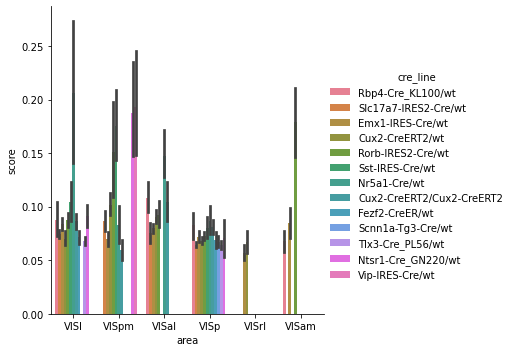

In [27]:
sns.catplot(x='area', y='score', hue='cre_line', kind='bar', data=results, palette = 'husl');

### Representational Similarity Regression

We can further analyse our feature maps with representational similarity analysis: in particular, a combination of nonnegative least squares regression and representational dissimilarity matrices.

In [28]:
sys.path.append('similarity')
from nnls_regression import *

The first step in this procedure is the calculation of RDMs from our thresholded neural data.

In [29]:
brain_rdms = {}
for area in sorted(cell_data['area'].unique()):
    brain_rdms[area] = {}
    for layer in sorted(cell_data[cell_data['area'] == area]['layer'].unique()):
        neural_site_subset = cell_data[(cell_data['area'] == area) & (cell_data['layer'] == layer)]['cell_specimen_id']
        target_cells = [cell for cell in neural_site_subset if cell in cell_subset]
        target_cell_responses = np.stack([cell_responses[cell] for cell in target_cells]).transpose()
        brain_rdms[area][layer] = np.corrcoef(target_cell_responses)

The second step is the calculation of RDMs from each layer of our target model.

In [30]:
model_rdms = {}
for model_layer in tqdm(feature_map_subset):
    model_rdms[model_layer] = np.corrcoef(feature_maps[model_layer])
    
model_rdm_stack = np.stack([model_rdms[model_layer] for model_layer in list(model_rdms.keys())], 2)

We then combine this into a cross-validated regression as follows:

In [31]:
nnls_dict_list = []
for area in tqdm(brain_rdms.keys(), leave = False):
    for layer in tqdm(brain_rdms[area].keys(), leave = False):
        brain_rdm = brain_rdms[area][layer]
        nnls = kfold_nonnegative_regression(brain_rdm, model_rdm_stack, regression_type='linear', n_splits=6)
        nnls_dict_list.append({'model': model_name, 'train_type': train_type, 'area': area, 'layer': layer, 'score': nnls[0]})

nnlsa = pd.DataFrame(nnls_dict_list)

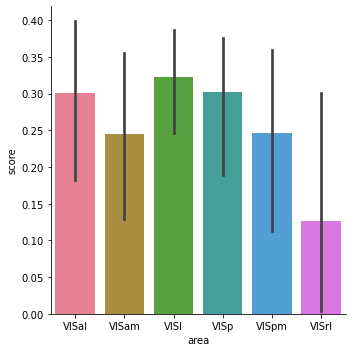

In [32]:
sns.catplot(x='area', y='score', kind='bar', data = nnlsa, palette = 'husl');